In [1]:
from ModelResult import ModelResult
import matplotlib.pyplot as plt
import numpy as np

Setup a model group for CanESM5 where the groups are based on which `1pctCO2` variant present in the filename.

In [2]:
m = ModelResult("/home/nate/data/ILAMB/MODELS/1pctCO2/CanESM5",name="CanESM5")
m.findFiles(group_regex=".*_(.*)_r1i1p1f1*")
print(m)

ModelResult: CanESM5
--------------------
  + 1pctCO2
  + 1pctCO2-bgc
  + 1pctCO2-rad



Extract the carbon variables we will need. In this case we do not need a multimodel mean and so we leave the keyword `mean` to its default `False`. For these fluxes we will accumulate the global total over the time period.

In [3]:
nbp   = m.getVariable(  "nbp")
fgco2 = m.getVariable("fgco2")
for key in nbp.keys():
    nbp  [key] = nbp  [key].integrateInSpace().accumulateInTime().convert("Pg")
    fgco2[key] = fgco2[key].integrateInSpace().accumulateInTime().convert("Pg")

We also require the temperature over the time period. Given that temperature is not accumulated and varies throughout a year, we will coarsen it to the mean global annual temperature.

In [4]:
tas = m.getVariable("tas")
y0,yf = np.round(nbp['1pctCO2'].time_bnds[[0,-1],[0,1]]/365)
years = np.asarray([np.arange(y0,yf),np.arange(y0+1,yf+1)]).T * 365. 
for key in nbp.keys():
    tas[key] = tas[key].integrateInSpace(mean=True).coarsenInTime(years)

To help interpret results and confirm that I have read the variables correctly, we show the trajectories of all 3 variables for each scenario below.

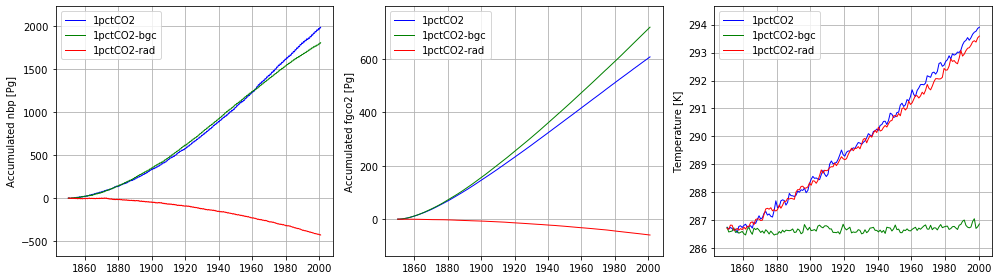

In [5]:
def setLimits(ax,v):
    vmin = 1e20; vmax = -1e20
    for key in v:
        vmin = min(vmin,v[key].data.min())
        vmax = max(vmax,v[key].data.max())
    dv = 0.1*(vmax-vmin)
    vmax += dv; vmin -= dv
    ax.set_ylim(vmin,vmax)
clr = {'1pctCO2':'b','1pctCO2-bgc':'g','1pctCO2-rad':'r'}
fig,ax = plt.subplots(figsize=(14,4),ncols=3,tight_layout=True)
for i,key in enumerate(nbp.keys()):
    nbp  [key].plot(ax[0],color=clr[key],label=key)
    fgco2[key].plot(ax[1],color=clr[key],label=key)
    tas  [key].plot(ax[2],color=clr[key],label=key)
setLimits(ax[0],nbp)
setLimits(ax[1],fgco2)
setLimits(ax[2],tas)
for i in range(3): ax[i].legend(loc=2)
ax[0].set_ylabel("Accumulated nbp [Pg]")
ax[1].set_ylabel("Accumulated fgco2 [Pg]")
ax[2].set_ylabel("Temperature [K]")
plt.show()

Now we compute the changes in carbon and climate and store these in dictionaries where the keys will be the `1pctCO2` variant which corresponds to the data. `dL` is for the change in carbon over land, `dO` is for the change over ocean, and `dT` is the change in temperature.

In [6]:
dL = {}; dO = {}; dT = {}
for key in   nbp: dL[key] =   nbp[key].data[-1]-  nbp[key].data[0]
for key in fgco2: dO[key] = fgco2[key].data[-1]-fgco2[key].data[0]
for key in   tas: dT[key] =   tas[key].data[-1]-  tas[key].data[0]

The change in atmospheric CO$_2$, can be computed by the knowledge that the model results were obtained by specifying a 1% annual growth of CO$_2$ ($r=0.01$) starting from an initial value of 284.7 [ppm]. The concentration increase from year 0 to year 1 is written as:

$$
C_{A,1} = C_{A,0} (1+r)
$$

and year 1 to year 2 as:

$$
\begin{align*}
C_{A,2} &= C_{A,1} (1+r)\\
        &= C_{A,0} (1+r)^2
\end{align*}
$$

or after $n$ years:

$$
C_{A,n} = C_{A,0} (1+r)^n
$$

So the change in carbon after $n$ years is:

$$
\begin{align*}
\Delta C_A &= C_{A,n} - C_{A,0}\\
           &= C_{A,0} ((1+r)^n-1)
\end{align*}
$$

If I understand correctly, this change in atmospheric carbon is the same for each variant because each simulation was driven with the same changes in CO$_2$ concentration. This varies from (*Friedlingstein, 2006*) where concentrations varied in their coupled and uncoupled runs.

In [7]:
C0 = 284.7 # [ppm]
r  = 0.01  # [1]
n  = yf-y0
dA = C0*((1+r)**n-1)
print("%.1f" % dA)

994.4


We can then compute the linear transient climate sensitivity ($\alpha$) to CO$_2$ using the coupled run `1pctCO2` in [K ppm-1].

In [8]:
alpha = dT['1pctCO2']/dA
print("alpha = %.4f" % alpha)

alpha = 0.0072


From what I understood from Forrest, we compute the $\beta$ terms [Pg ppm-1] using the `1pctCO2-bgc` data,

In [9]:
betaL = dL['1pctCO2-bgc']/dA
betaO = dO['1pctCO2-bgc']/dA
print("betaL = %.1f, betaO = %.1f" % (betaL,betaO))

betaL = 1.8, betaO = 0.7


and then we use these $\beta$ values with the `1pctCO2-rad` runs to compute the $\gamma$ values [Pg K-1],

In [10]:
gammaL = (dL['1pctCO2-rad']-betaL*dA)/dT['1pctCO2-rad']
gammaO = (dO['1pctCO2-rad']-betaO*dA)/dT['1pctCO2-rad']
print("gammaL = %d, gammaO = %d" % (gammaL,gammaO))

gammaL = -325, gammaO = -113


These values are larger in magnitude than those in Table 3 of (*Friedlingstein, 2006*) but not completely unreasonable. Then we can compute the carbon cycle gain [1],

In [11]:
g = -alpha*(gammaL+gammaO)/(1+betaL+betaO)
print("g = %.2f" % g)

g = 0.89
